# Imports and Functions

In [46]:
import pandas as pd
from time import time

import visuals as vs 

%matplotlib inline

In [80]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
flatui = ["#9b59b6","#3498db","#95a5a6","#e74c3c","#34495e","#2ecc71"]
sns.set_palette(flatui) 
sns.set(font_scale=1.5)

def conf_matrix(y_test, preds, classes, normalize_conf_mat=False, figsize=(40,40)):    
    conf_mat = confusion_matrix(preds, y_test, labels=classes)
    fig, ax = plt.subplots(figsize=figsize)
    
    # normalize by row
    if normalize_conf_mat:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] #normalização dos valores 
        df_cm = pd.DataFrame(conf_mat, index=classes, #cria um data frame para base ao gráfico
                          columns=classes)        
        sns.heatmap(df_cm, cmap='BuPu', annot=True, 
                    xticklabels=classes, yticklabels=classes)
    else: 
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu",
                xticklabels=classes, yticklabels=classes)
        
    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import scikitplot as skplt

def train(model, X_train, y_train):
    clf = Pipeline([('vect', TfidfVectorizer(min_df=3,  max_features=None, 
                    strip_accents='unicode', analyzer='word',tokenizer=word_tokenize,
                    ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)),
                    ('clf', model)
                  ])
    
    clf.fit(X_train.tolist(), y_train)
    
    model_name = type(clf.named_steps['clf']).__name__    
    preds = clf.predict(X_train)
    acc = np.mean(preds == y_train)
    print(f'{model_name}: train accuracy {acc}')
    
    return clf, acc
    
def evaluate_(clf, X_test, y_test, verbose=False, normalize_conf_mat=False):
    model_name = type(clf.named_steps['clf']).__name__    
    y_pred = clf.predict(X_test)
    acc = np.mean(y_pred == y_test)
    print(f'{model_name}: test accuracy {acc}')
    
    y_probas = clf.predict_proba(X_test)
          
    if verbose:        
        show_roc(y_test, y_probas, model_name)    
        show_report(y_test, y_pred)
        conf_matrix(y_test, y_pred, clf.classes_, normalize_conf_mat)
        
    return acc
          
def train_evaluate(model, X_train, y_train, X_test, y_teste, verbose=False, normalize_conf_mat=False):
    clf, acc_train = train(model, X_train, y_train)
    acc_test = evaluate(clf, X_test, y_test, verbose, normalize_conf_mat)
    return clf, acc_train, acc_test
        
          
def show_roc(y_test, y_probas, name, figsize=(40,40)):
    skplt.metrics.plot_roc(y_test, y_probas,  plot_macro=False, plot_micro=False, figsize=figsize)
    plt.tight_layout()
    plt.title(name)
    plt.show()
          
def show_report(y_test, y_pred):
    #print('roc_auc_score %s' % roc_auc_score(y_test, y_pred)) 
    #print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))

# Load Data

In [3]:
df_data = pd.read_csv('../data/data_feat.csv')
df_data.head()

,SUBJECT,AUTHOR,TEXT,TEXT_CLEAN,NUM_STOPWORDS,NUM_PUNCTUATIONS,NUM_WORDS_UPPER,NUM_CHARS,NUM_WORDS,AVG_WORD
0,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,19/03/2009\nFATO CORRIQUEIRO\nO fato mais impo...,19 03 2009 fato corriqueiro fato importante se...,67,29,5,1375,199,5.787129
1,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,06/07/2009\nPOLÍTICA DE ESTADO\nUm problema cr...,06 07 2009 politica estado problema cronico po...,75,29,11,1342,207,5.449275
2,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,12/07/2009\nTOQUE DE RECOLHER\nProcurado para ...,12 07 2009 toque recolher procurado suspender ...,95,46,11,1587,257,5.180392
3,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,23/03/2009\nCRISE SOCIOEDUCATIVA\nOcorreram du...,23 03 2009 crise socioeducativa ocorreram duas...,55,26,6,1141,167,5.761905
4,ASSUNTOS VARIADOS,LUIZ FLAVIO SAPORI,24/12/2008\nESTATÍSTICAS CRIMINAIS CONFIÁVEIS\...,24 12 2008 estatisticas criminais confiaveis b...,133,43,17,2309,366,5.246612


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 10 columns):
SUBJECT             3003 non-null object
AUTHOR              3003 non-null object
TEXT                3003 non-null object
TEXT_CLEAN          3003 non-null object
NUM_STOPWORDS       3003 non-null int64
NUM_PUNCTUATIONS    3003 non-null int64
NUM_WORDS_UPPER     3003 non-null int64
NUM_CHARS           3003 non-null int64
NUM_WORDS           3003 non-null int64
AVG_WORD            3003 non-null float64
dtypes: float64(1), int64(5), object(4)
memory usage: 234.7+ KB


# Prep Data

In [5]:
df_data['SUBJECT'] = df_data['SUBJECT'].astype('category')
df_data['AUTHOR'] = df_data['AUTHOR'].astype('category')

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_data['TEXT_CLEAN'], df_data['AUTHOR'],
                                                    test_size=0.2, stratify=df_data['AUTHOR'], random_state=42)

In [7]:
print(f'train size {len(X_train)}')
print(f'test size {len(X_test)}')

train size 2402
test size 601


# Baseline

In [8]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import f1_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end-start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
            
    # Compute accuracy on the training samples 
    results['acc_train'] = accuracy_score(y_train,predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the training samples using fbeta_score()
    results['f1_train'] = f1_score(y_train,predictions_train,average='micro')
        
    # Compute F-score on the test set which is y_test
    results['f1_test'] = f1_score(y_test,predictions_test,average='micro')
       
    # Success
    if learner.__class__.__name__ == 'Pipeline':
        print("{} trained on {} samples.".format(type(learner.named_steps['clf']).__name__, sample_size)) 
    else:
        print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [24]:
# Import the three supervised learning models from sklearn
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(min_df=3,  max_features=None, analyzer='word',tokenizer=word_tokenize,
                    ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)

# Initialize the three models
clf_A = Pipeline([('vect', tfidf_vec),
                  ('clf', LogisticRegression(solver='lbfgs', random_state=42, n_jobs=-1))
                 ])

clf_B = Pipeline([('vect', tfidf_vec), 
                  ('clf', SGDClassifier(random_state=42, n_jobs=-1))
                 ])

clf_C = Pipeline([('vect', tfidf_vec), 
                  ('clf', MLPClassifier(learning_rate='adaptive', early_stopping=True, random_state=42))
                 ])

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train)/100)
samples_10 = int(len(X_train)/10)
samples_100 = int(len(X_train))

In [25]:
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    if clf.__class__.__name__ == 'Pipeline':
        clf_name = type(clf.named_steps['clf']).__name__
    else:
        clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression trained on 24 samples.
LogisticRegression trained on 240 samples.
LogisticRegression trained on 2402 samples.


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier trained on 24 samples.
SGDClassifier trained on 240 samples.
SGDClassifier trained on 2402 samples.
MLPClassifier trained on 24 samples.
MLPClassifier trained on 240 samples.
MLPClassifier trained on 2402 samples.


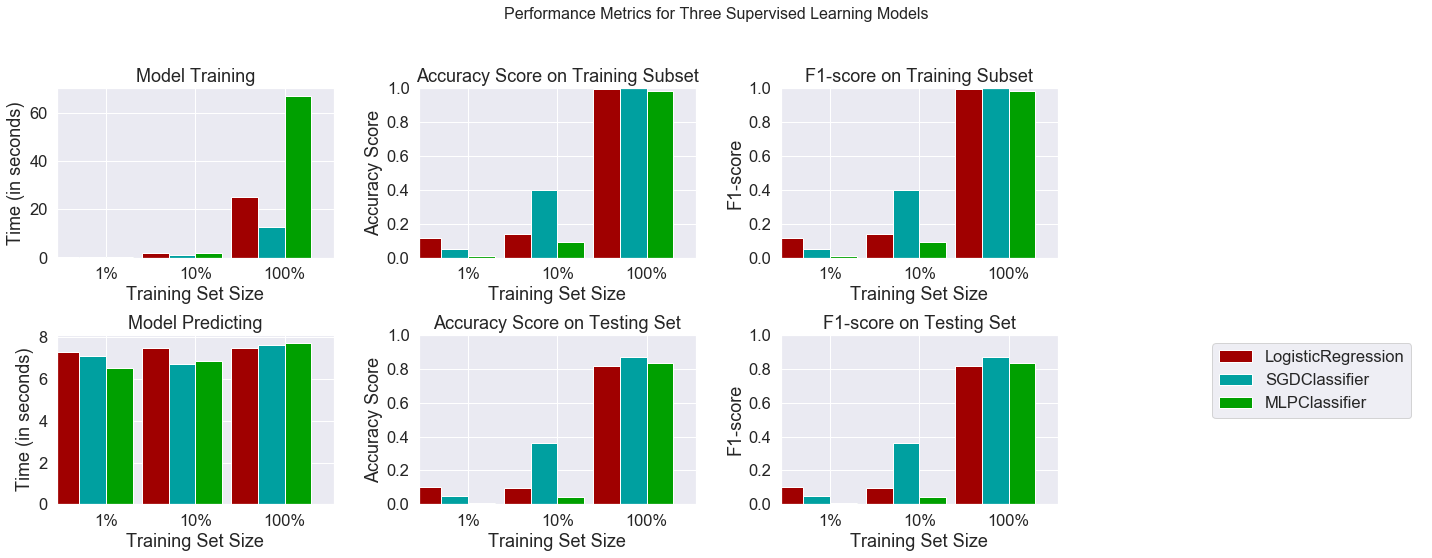

In [26]:
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, None, None)

In [27]:
print(f"LogisticRegression: {results['LogisticRegression'][2]['f1_test']}")
print(f"SGDClassifier: {results['SGDClassifier'][2]['f1_test']}")
print(f"MLPClassifier: {results['MLPClassifier'][2]['f1_test']}")

LogisticRegression: 0.8153078202995009
SGDClassifier: 0.8718801996672213
MLPClassifier: 0.8319467554076541


In [64]:
ppl = Pipeline([('vect', tfidf_vec), 
                ('clf', SGDClassifier(loss='log', random_state=42, n_jobs=-1))
               ])
ppl.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=1,
   ...dom_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [65]:
preds_test = ppl.predict(X_test)
preds_train = ppl.predict(X_train)

In [66]:
print(f'Train acc: {accuracy_score(y_train,preds_train)}')        
print(f'Test acc: {accuracy_score(y_test,preds_test)}')
print(f'Train f1-score: {f1_score(y_train,preds_train,average="micro")}')
print(f'Text f1-score: {f1_score(y_test,preds_test,average="micro")}')

Train acc: 1.0
Test acc: 0.8452579034941764
Train f1-score: 1.0
Text f1-score: 0.8452579034941764


In [67]:
show_report(y_test, preds_test)

                         precision    recall  f1-score   support

    ACÍLIO LARA REZENDE       0.71      0.83      0.77         6
      ADRIANO GAMBARINI       1.00      1.00      1.00         6
      ALESSANDRA BLANCO       0.75      1.00      0.86         6
    ALEXANDRE MAGALHÃES       0.83      0.83      0.83         6
ANA CRISTINA CAVALCANTE       1.00      1.00      1.00         6
          ANDRE RIBEIRO       1.00      0.83      0.91         6
        ANDREA KAUFMANN       1.00      1.00      1.00         6
    ANTONIO PIETROBELLI       1.00      1.00      1.00         6
          ARNALDO JABOR       1.00      1.00      1.00         6
          AUGUSTO MAFUZ       1.00      1.00      1.00         6
          BADGER VICARI       1.00      0.83      0.91         6
        BENEDICTO DUTRA       1.00      1.00      1.00         6
      BOLESLAU SLIVIANY       1.00      1.00      1.00         6
           CARLA KREEFT       1.00      1.00      1.00         6
      CARLOS BERTOLAZZI 

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


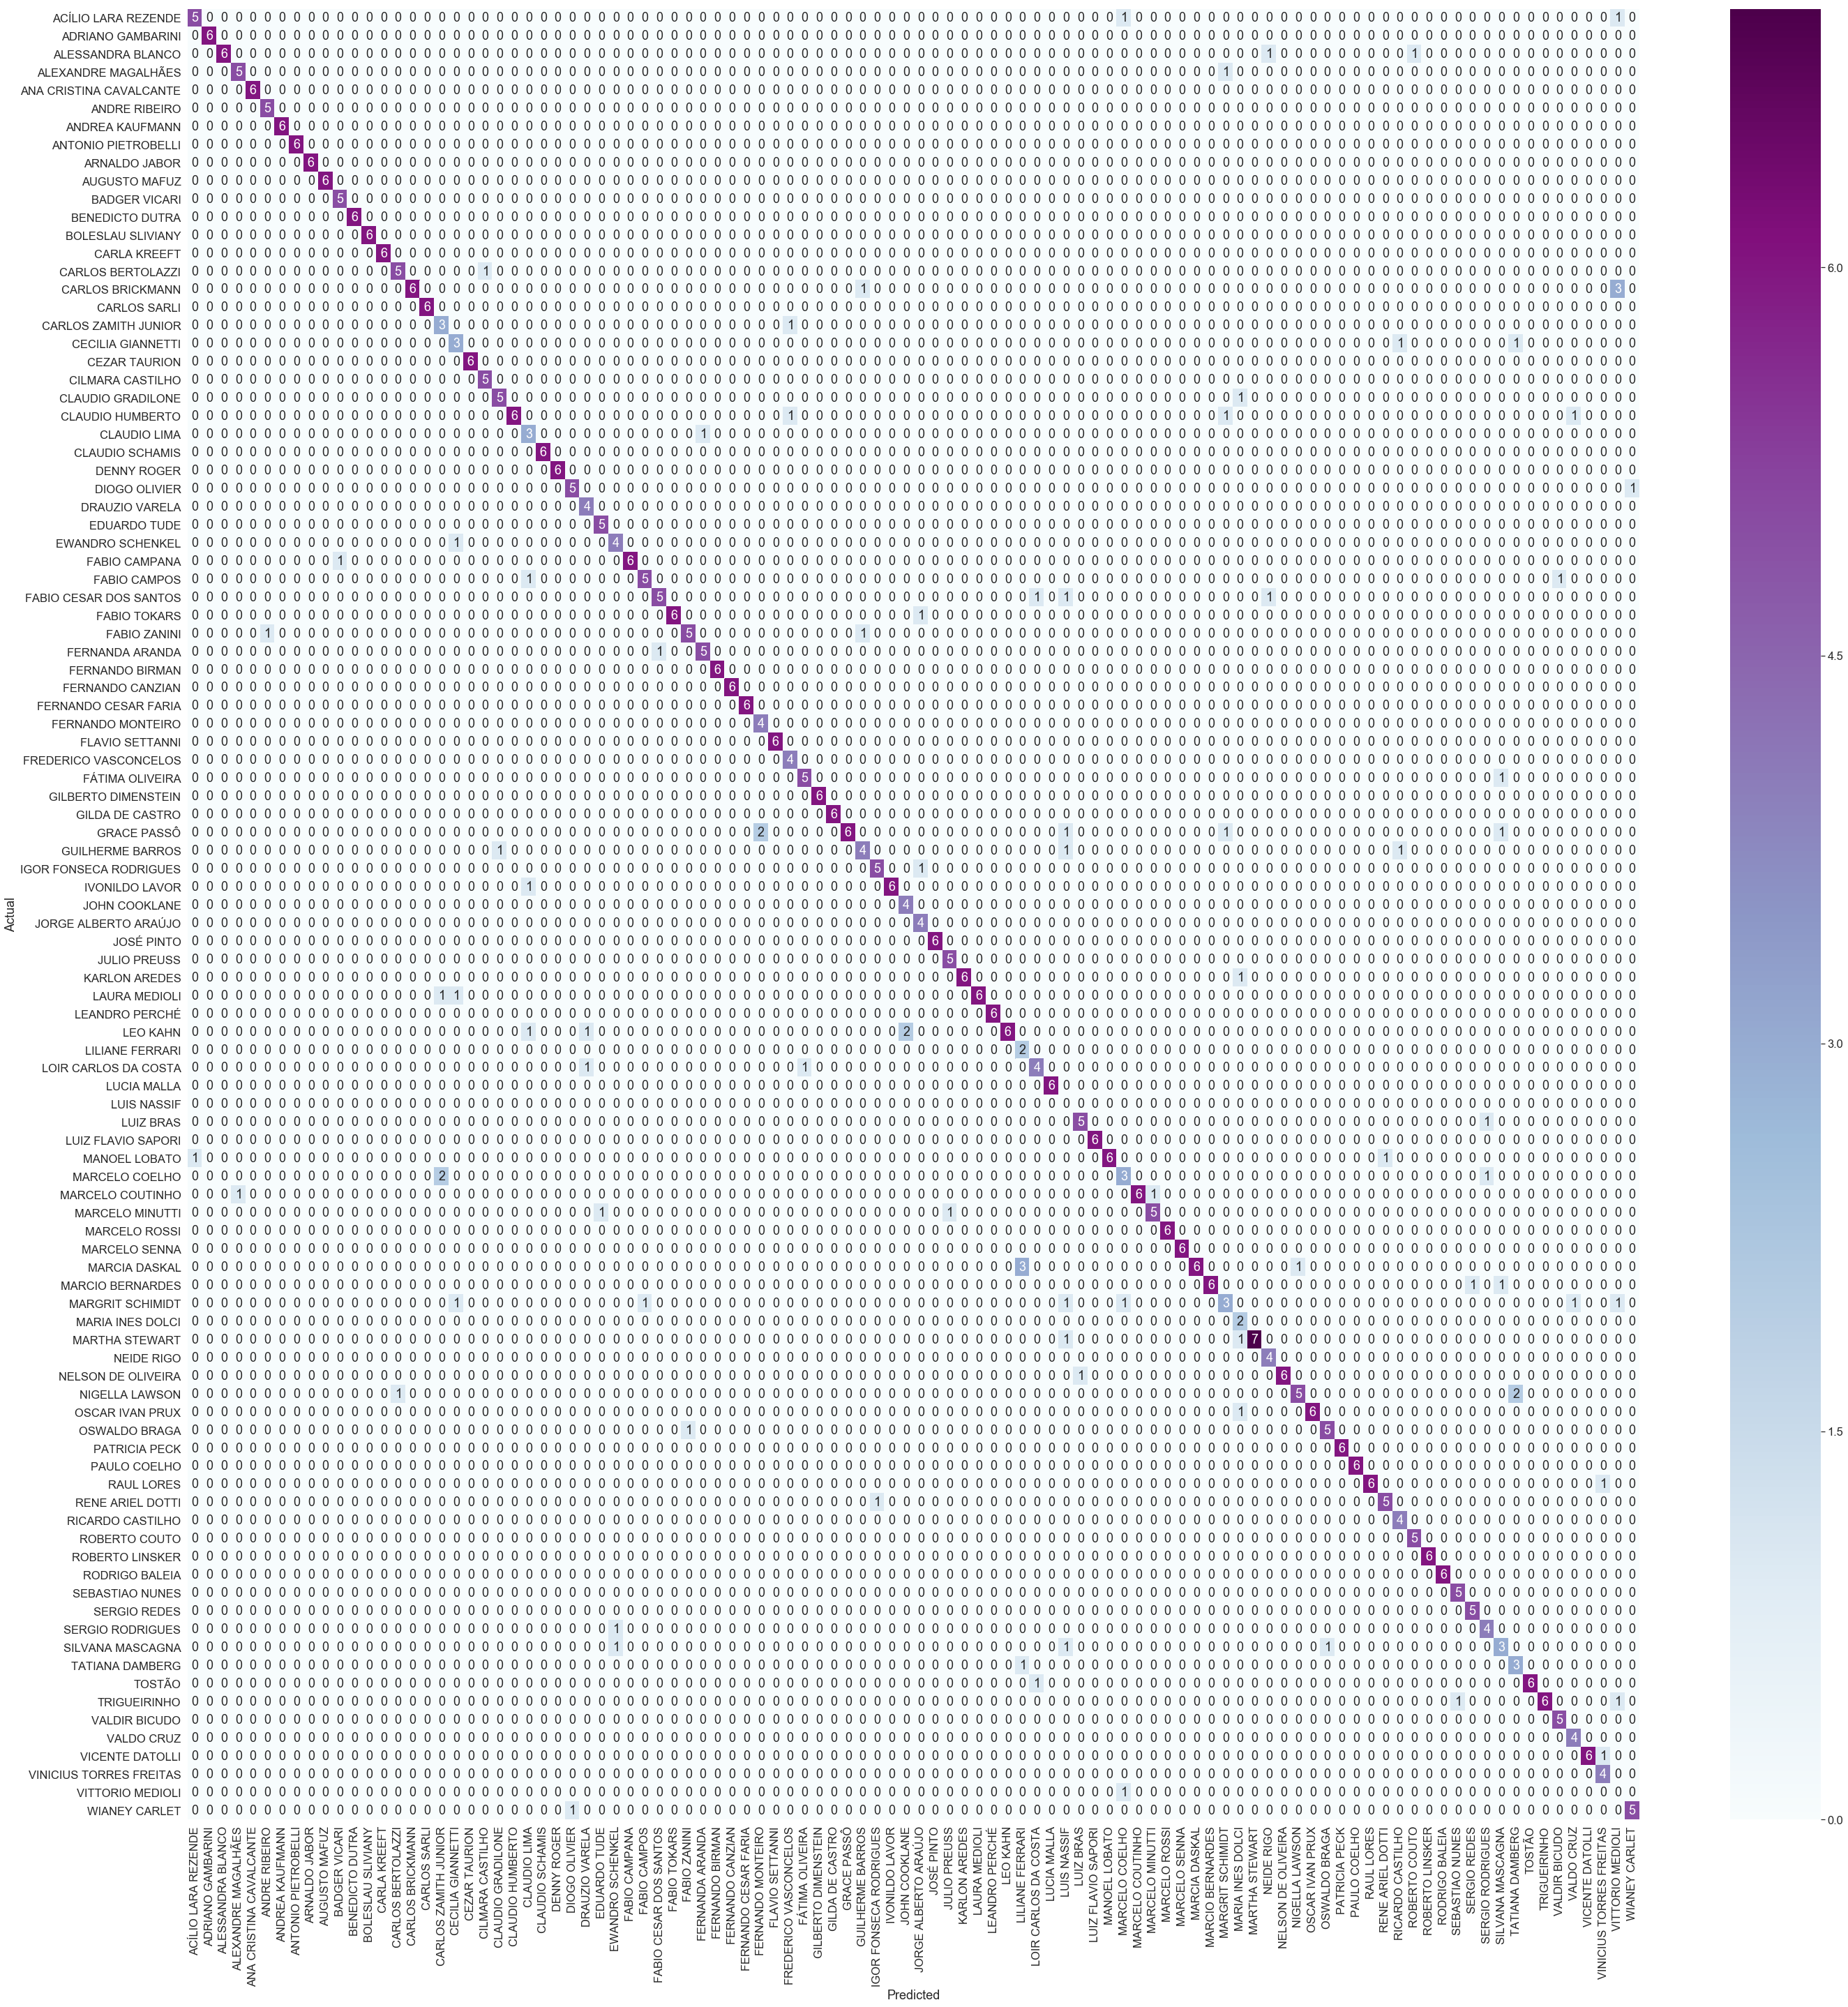

In [81]:
conf_matrix(y_test, preds_test, ppl.classes_, False)

In [69]:
y_probas = ppl.predict_proba(X_test)

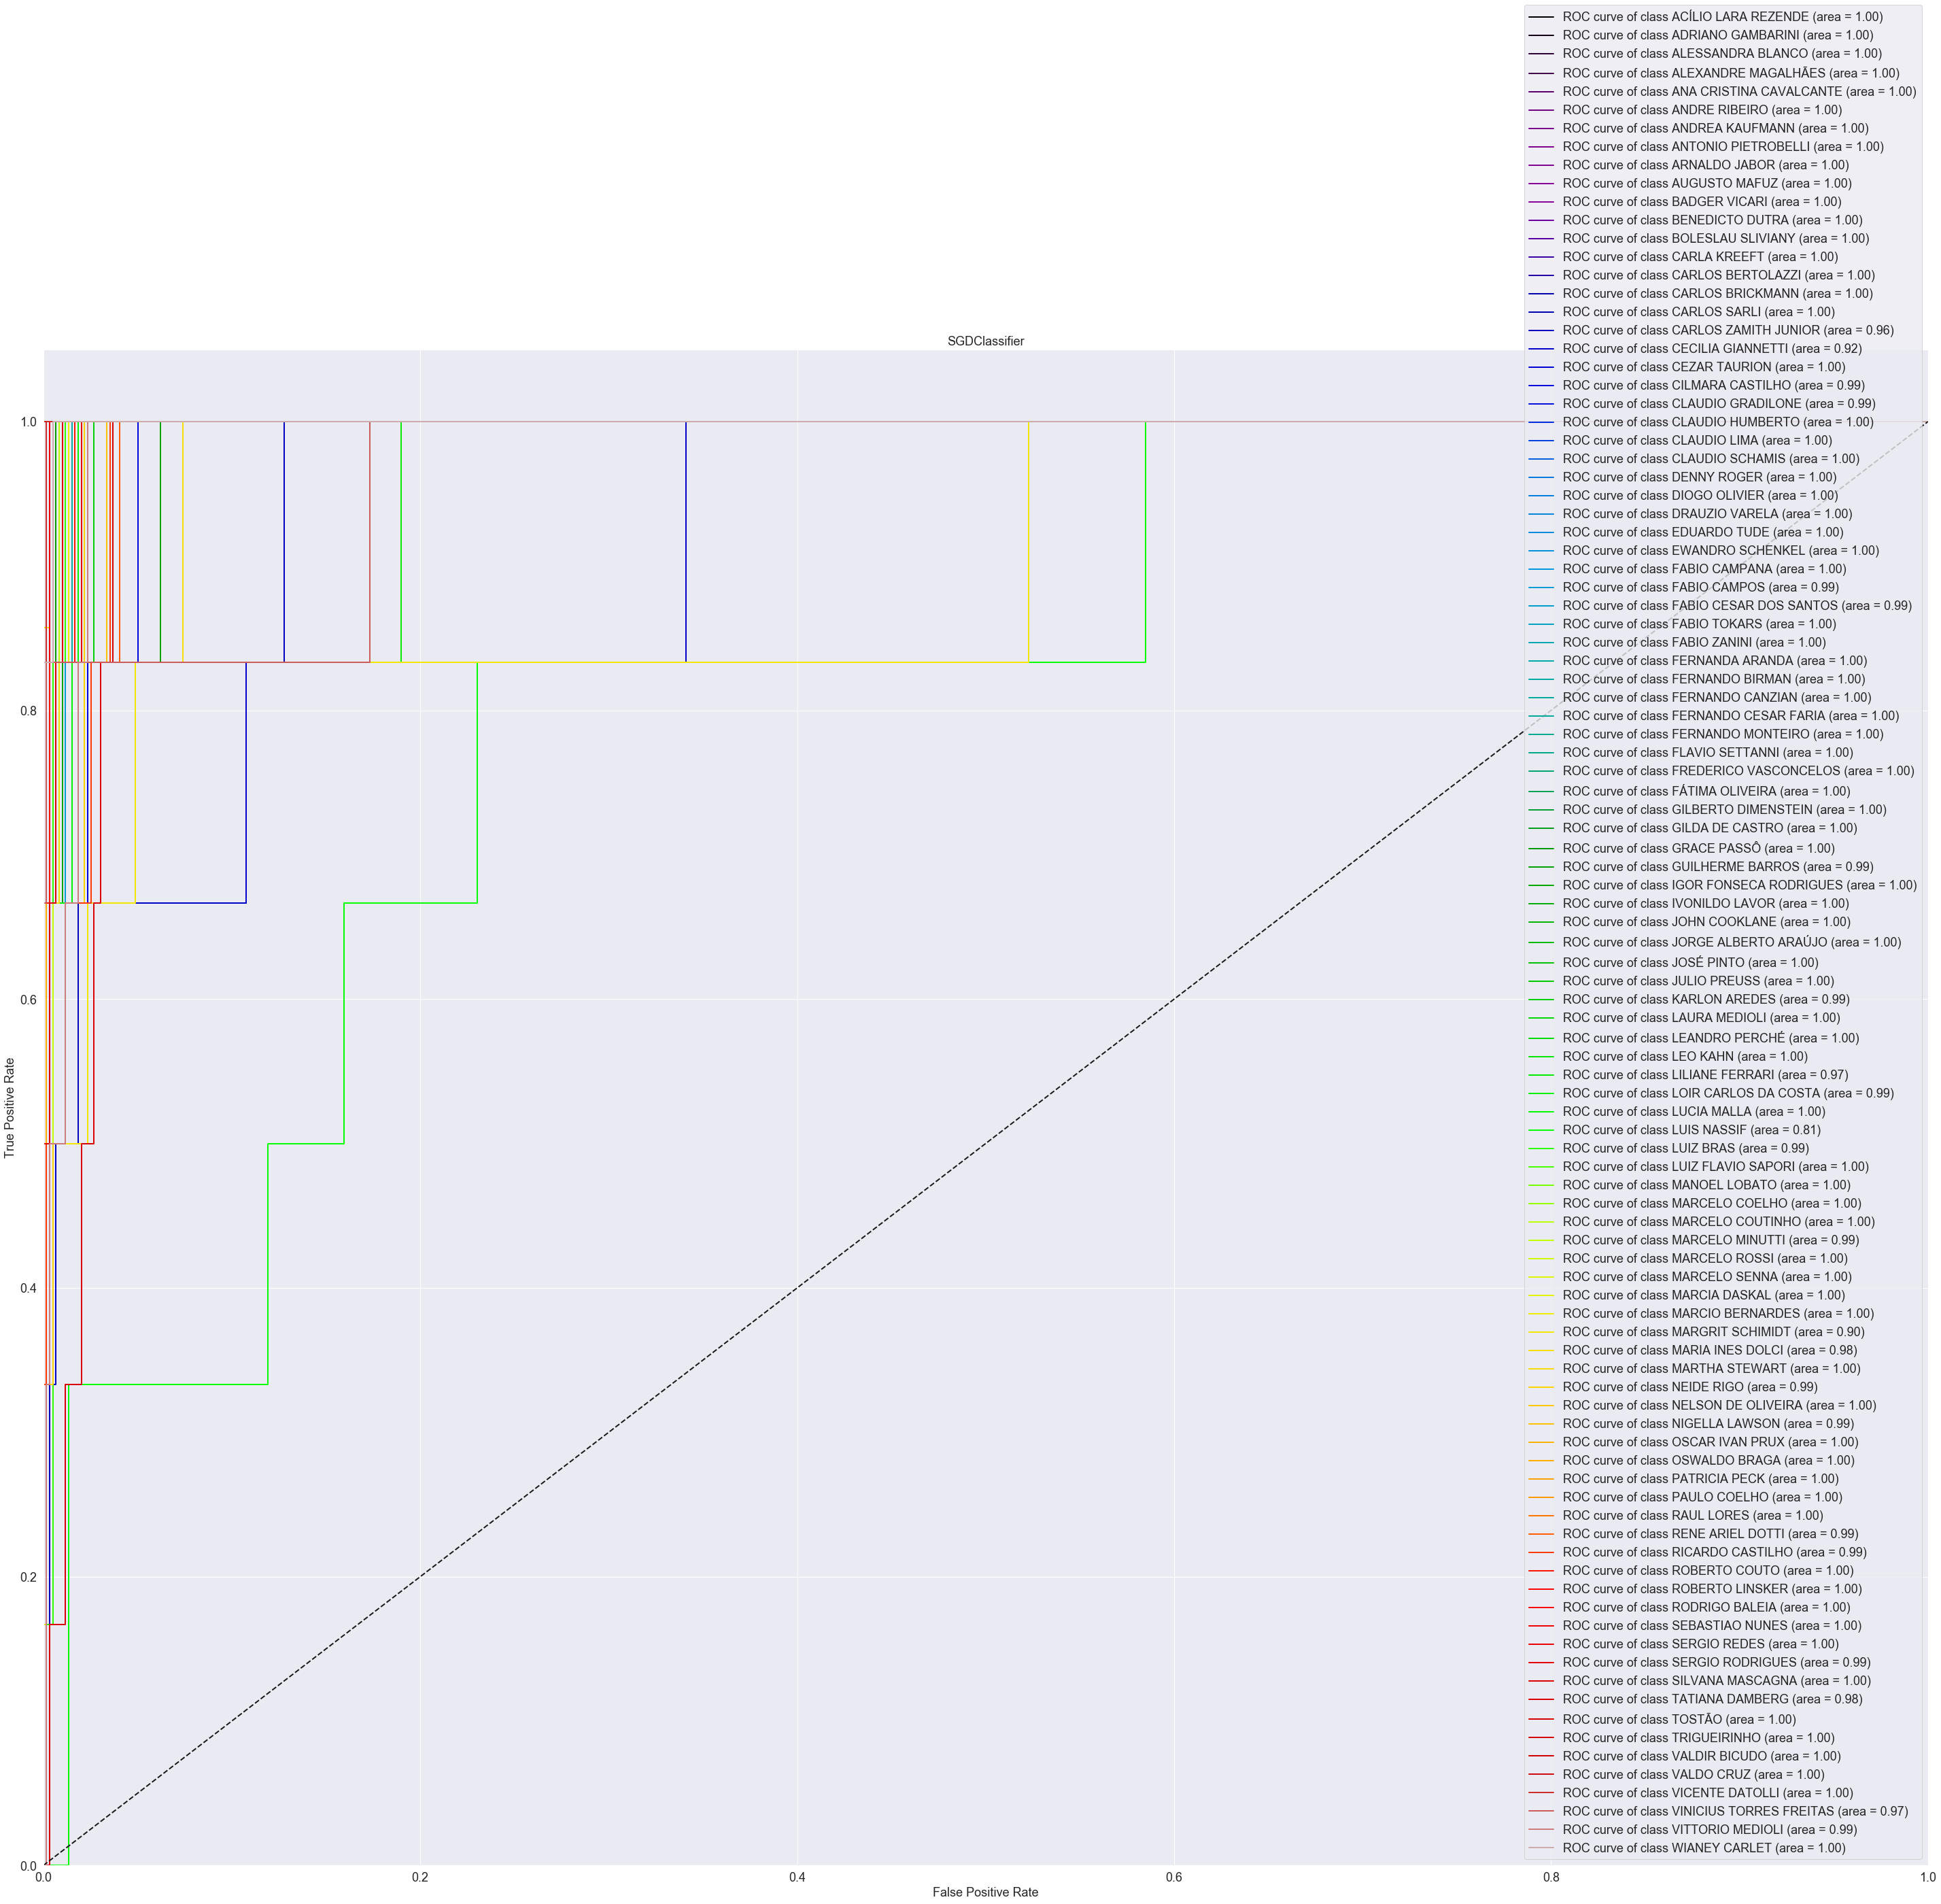

In [83]:
show_roc(y_test, y_probas, type(ppl.named_steps['clf']).__name__ )

## GridSearch

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import SGDClassifier


# Initialize the classifier
pipe = Pipeline([('vect', tfidf_vec), 
                ('clf', SGDClassifier())
               ])

# the parameters list.
parameters = {
    'clf__loss': ['log', 'hinge', 'modified_huber'],
    'clf__validation_fraction': [0.1, 0.2],
    'clf__random_state': [42],
    'clf__n_jobs': [-1]
}

# Make an f1_score scoring object using make_scorer()
scorer = make_scorer(f1_score, average='micro')

In [29]:
# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(pipe, parameters,scoring=scorer, cv=5)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [31]:
# Get the estimator
best_clf = grid_fit.best_estimator_
print(best_clf)

best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Optimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F1-score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions)))

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=1,
   ...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])
Optimized Model
------
Final accuracy score on the testing data: 0.7471


ValueError: Target is multiclass but average='binary'. Please choose another average setting.

```
Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=1,
   ...m_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))])
Optimized Model
------
Final accuracy score on the testing data: 0.7471
```

# CrossValidation